# U.S. Geological Survey Class GW3099

Advanced Modeling of Groundwater Flow (GW3099) <br>
Boise, Idaho <br>
September 16 - 20, 2024 <br>

# ![title](../../images/ClassLocation.jpg)

# Particle tracking example 3: forward tracking, transient flow

This notebook demonstrates particle tracking with a transient flow system, based on [Example 3](https://modflow6-examples.readthedocs.io/en/develop/_notebooks/ex-prt-mp7-p03.html) from the MODPATH 7 user guide. The flow system includes two wells, a drain, and a river.

The original problem runs PRT as a post-processor for a flow model. We demonstrate the use of a GWF-PRT exchange to combine the two models in a single simulation.

The original problem involves distinguishing particles terminating at each boundary. We extend the example to determine well pumping rates sufficient to keep the particles out of the drain and river.

Import dependencies.

In [69]:
import pathlib as pl
import warnings

import flopy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Enable inline plotting.

In [70]:
%matplotlib inline

Ignore some warnings.

In [71]:
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", DeprecationWarning)

Make sure MODPATH 7 is installed.

In [72]:
# flopy.utils.get_modflow(":python", subset="mp7")

Create a base workspace.

In [73]:
example_name = "ex3"
base_ws = pl.Path("temp") / example_name
base_ws.mkdir(exist_ok=True, parents=True)

# Reproducing the example

We start by reproducing the results in the cited example, this time with a flow model and a tracking model occupying the same simulation.

First define a workspace and model names.

In [74]:
gwf_name = f"{example_name}-gwf"
prt_name = f"{example_name}-prt"
demo_ws = base_ws / "demo"

Define model units.

In [75]:
length_units = "feet"
time_units = "days"

Define flow model parameters.

In [76]:
nper = 3  # Number of periods
nlay = 3  # Number of layers
nrow = 21  # Number of rows
ncol = 20  # Number of columns
delr = 500.0  # Column width ($ft$)
delc = 500.0  # Row width ($ft$)
top = 350.0  # Top of the model ($ft$)
botm = [220.0, 200.0, 0.0]  # Layer bottom elevations ($ft$)
kh = [50.0, 0.01, 200.0]  # Horizontal hydraulic conductivity ($ft/d$)
kv = [10.0, 0.01, 20.0]  # Vertical hydraulic conductivity ($ft/d$)
rchv = 0.005  # Recharge rate ($ft/d$)
riv_h = 320.0  # River stage ($ft$)
riv_z = 317.0  # River bottom ($ft$)
riv_c = 1.0e5  # River conductance ($ft^2/d$)
porosity = 0.1  # Soil porosity (unitless)

Define boundary conditions.

In [77]:
# Define well data.
# Negative discharge indicates pumping, positive injection.
wells = [
    # layer, row, col, discharge
    (0, 10, 9, -75000),
    (2, 12, 4, -100000),
]

# Define the drain location.
drain = (0, 14, (9, 20))

# Define the river data.
riv_iface = 6
riv_iflowface = -1
rd = []
for i in range(nrow):
    rd.append(
        [(0, i, ncol - 1), riv_h, riv_c, riv_z, riv_iface, riv_iflowface]
    )

Calculate node numbers for the boundary conditions.

In [78]:
nodes = {"well1": [], "well2": [], "drain": [], "river": []}
for idx, (k, i, j, _) in enumerate(wells):
    nodes[f"well{idx + 1}"].append(ncol * (nrow * k + i) + j)
for j in drain[2]:
    k, i = drain[:2]
    nodes["drain"].append([ncol * (nrow * k + i) + j])
for rivspec in rd:
    k, i, j = rivspec[0]
    node = ncol * (nrow * k + i) + j
    nodes["river"].append(node)

Configure a zone mapping.

In [79]:
def get_izone():
    izone = []

    # zone 1 is the default (non-terminating)
    def ones():
        return np.ones((nrow, ncol), dtype=np.int32)

    # layer 1
    l1 = ones()
    l1[wells[0][1:3]] = 2  # well
    l1[drain[1], drain[2][0] : drain[2][1]] = 4  # drain
    l1[:, ncol - 1] = 5  # river
    izone.append(l1)

    # layer 2
    izone.append(1)

    # layer 3
    l3 = ones()
    l3[wells[1][1:3]] = 3  # well
    izone.append(l3)

    return izone


izone = get_izone()

Construct a simulation.

In [80]:
sim = flopy.mf6.MFSimulation(
    sim_name=example_name, exe_name="mf6", version="mf6", sim_ws=demo_ws
)

Create the time discretization.

In [81]:
tdis_pd = [
    # perlen, nstp, tsmult
    (100000, 1, 1),
    (36500, 10, 1.5),
    (100000, 1, 1),
]
tdis = flopy.mf6.modflow.mftdis.ModflowTdis(
    sim,
    pname="tdis",
    time_units=time_units,
    nper=len(tdis_pd),
    perioddata=tdis_pd,
)

Create the groundwater flow model.

In [82]:
model_nam_file = f"{gwf_name}.nam"
gwf = flopy.mf6.ModflowGwf(
    sim, modelname=gwf_name, model_nam_file=model_nam_file, save_flows=True
)

Create the iterative model solver package for the flow model.

In [83]:
ims = flopy.mf6.modflow.mfims.ModflowIms(
    sim,
    pname="ims",
    complexity="SIMPLE",
)
sim.register_solution_package(ims, [gwf.name])

Create the grid discretization.

In [84]:
dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(
    gwf,
    pname="dis",
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    length_units="FEET",
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
)

Create the initial conditions package.

In [85]:
ic = flopy.mf6.modflow.mfgwfic.ModflowGwfic(gwf, pname="ic", strt=320)

Create the node property flow package.

In [86]:
npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(
    gwf,
    pname="npf",
    icelltype=[1, 0, 0],  # top layer convertible
    k=kh,
    k33=kv,
    save_flows=True,
    save_specific_discharge=True,
    save_saturation=True,
)

Create the recharge package.

In [87]:
rch = flopy.mf6.modflow.mfgwfrcha.ModflowGwfrcha(gwf, recharge=rchv)

Create the storage package.

In [88]:
sto = flopy.mf6.modflow.mfgwfsto.ModflowGwfsto(
    gwf,
    save_flows=True,
    iconvert=1,
    ss=0.0001,
    sy=0.1,
    steady_state={0: True, 2: True},
    transient={1: True},
)

Create the well package.

In [89]:
def no_flow(w):
    return w[0], w[1], w[2], 0


nf_wells = [no_flow(w) for w in wells]
wel = flopy.mf6.modflow.mfgwfwel.ModflowGwfwel(
    gwf,
    maxbound=2,
    stress_period_data={0: nf_wells, 1: wells, 2: wells},
)

Create the river package.

In [90]:
riv = flopy.mf6.modflow.mfgwfriv.ModflowGwfriv(
    gwf, auxiliary=["iface", "iflowface"], stress_period_data={0: rd}
)

Create the drain package.

In [91]:
drn_iface = 6
drn_iflowface = -1
dd = [
    [
        drain[0],
        drain[1],
        i + drain[2][0],
        322.5,
        100000.0,
        drn_iface,
        drn_iflowface,
    ]
    for i in range(drain[2][1] - drain[2][0])
]
drn = flopy.mf6.modflow.mfgwfdrn.ModflowGwfdrn(
    gwf,
    auxiliary=["iface", "iflowface"],
    maxbound=11,
    stress_period_data={0: dd},
)

Create the flow model output control package.

In [92]:
headfile = f"{gwf_name}.hds"
budgetfile = f"{gwf_name}.cbb"
oc = flopy.mf6.modflow.mfgwfoc.ModflowGwfoc(
    gwf,
    pname="oc",
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    head_filerecord=[headfile],
    budget_filerecord=[budgetfile],
)

Create the particle tracking model.

In [93]:
prt = flopy.mf6.ModflowPrt(
    sim, modelname=prt_name, model_nam_file="{}.nam".format(prt_name)
)

Create the particle tracking model's discretization package.

In [94]:
prtdis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(
    prt,
    pname="dis",
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    length_units="FEET",
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
)

Create the particle tracking model input package. This includes global settings like porosity and the zone mapping.

In [95]:
mip = flopy.mf6.ModflowPrtmip(prt, pname="mip", porosity=porosity, izone=izone)

Create a particle release package. For convenience, we will define a particle release template for MODPATH 7 and convert it to PRT format.

We use the `localz` option to position release points vertically with respect to the water table.

In [96]:
# Define a MODPATH 7 release configuration.
rel_minl = rel_maxl = 0
rel_minr = 2
rel_maxr = 3
rel_minc = 2
rel_maxc = 3
celldata = flopy.modpath.CellDataType(
    drape=0,
    rowcelldivisions=5,
    columncelldivisions=5,
    layercelldivisions=1,
)
lrcregions = [[rel_minl, rel_minr, rel_minc, rel_maxl, rel_maxr, rel_maxc]]
lrcpd = flopy.modpath.LRCParticleData(
    subdivisiondata=[celldata],
    lrcregions=[lrcregions],
)

Exercise: define an equivalent configuration without using any MP7 utilities.

In [97]:
prt_release_points = np.sort(
    np.mgrid[1050:2000:100, 8550:9500:100].astype(float).reshape(2, -1).T,
    axis=0,
)

prt_release_points = np.insert(prt_release_points, 2, 0.5, axis=1)

mp7_release_points = np.sort(
    np.array(list(lrcpd.to_coords(prt.modelgrid, localz=True))), axis=0
)

assert np.allclose(mp7_release_points, prt_release_points)

Define release times. The first release occurs 90,000 days into the simulation, with releases continuing every 20 days, for 200 days.

In [98]:
release_times = list(range(90000, 90200, 20))

We can now create the particle release point package.

In [99]:
release_points = list(lrcpd.to_prp(prt.modelgrid, localz=True))
prp = flopy.mf6.ModflowPrtprp(
    prt,
    pname="prp1",
    filename="{}_1.prp".format(prt_name),
    nreleasepts=len(release_points),
    packagedata=release_points,
    nreleasetimes=len(release_times),
    releasetimes=[(t,) for t in release_times],
    # local z coordinates specified, compute global release
    # coord from cell top if saturated or water table if not
    local_z=True,
    exit_solve_tolerance=1e-5,
    extend_tracking=True,
)

Create the particle tracking model output control package.

In [100]:
budgetfile_prt = f"{prt_name}.cbb"
trackfile_prt = f"{prt_name}.trk"
trackhdrfile_prt = f"{prt_name}.trk.hdr"
trackcsvfile_prt = f"{prt_name}.trk.csv"
track_times = list(range(90000, 150001, 1000))
oc = flopy.mf6.ModflowPrtoc(
    prt,
    pname="oc",
    budget_filerecord=[budgetfile_prt],
    trackcsv_filerecord=[trackcsvfile_prt],
    track_release=True,
    track_terminate=True,
    track_usertime=True,
    ntracktimes=len(track_times),
    tracktimes=[(t,) for t in track_times],
    saverecord=[("BUDGET", "ALL")],
)

Create the PRT exchange.

In [101]:
exg = flopy.mf6.ModflowGwfprt(
    sim,
    exgtype="GWF6-PRT6",
    exgmnamea=gwf_name,
    exgmnameb=prt_name,
    filename=f"{gwf_name}.gwfprt",
)

Create an explicit model solution for the particle tracking model.

In [102]:
ems = flopy.mf6.ModflowEms(
    sim,
    pname="ems",
    filename=f"{prt_name}.ems",
)
sim.register_solution_package(ems, [prt.name])

Write and run the simulation.

In [103]:
sim.write_simulation()
sim.run_simulation(silent=False)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing solution package ems...
  writing package ex3-gwf.gwfprt...
  writing model ex3-gwf...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package sto...
    writing package wel_0...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 21 based on size of stress_period_data
    writing package drn_0...
    writing package oc...
  writing model ex3-prt...
    writing model name file...
    writing package dis...
    writing package mip...
    writing package prp1...
    writing package oc...
FloPy is using the following executable to run the model: ../../../../../../../micromamba/envs/gw3099/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
     

(True, [])

Retrieve head results.

In [104]:
gwf = sim.get_model(gwf_name)
head = gwf.output.head().get_data()

Retrieve pathlines.

In [105]:
prt = sim.get_model(prt_name)
pathlines = pd.read_csv(demo_ws / trackcsvfile_prt)
term_pts = pathlines[pathlines.ireason == 3]
term_pts.t.describe()

count      1000.000000
mean     132506.792074
std       13658.238789
min      107216.919283
25%      118900.134134
50%      135914.347983
75%      141985.567819
max      160352.526430
Name: t, dtype: float64

Plot results.

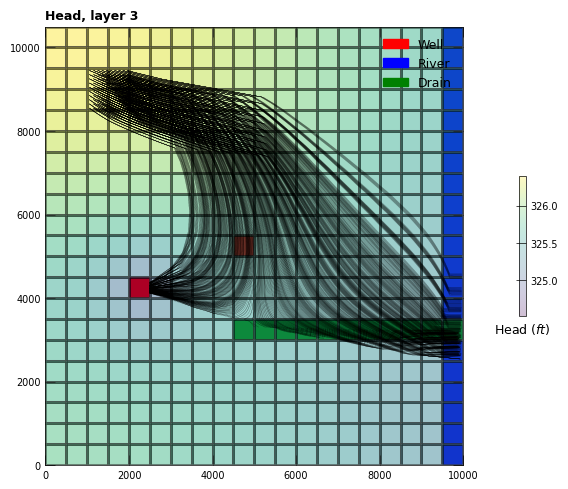

In [106]:
from matplotlib.patches import Patch


def plot_heads(ax, gwf, heads):
    mm = flopy.plot.PlotMapView(gwf, ax=ax, layer=2)
    mm.plot_grid(alpha=0.25)
    mm.plot_bc("WEL", plotAll=True, color="red")
    mm.plot_bc("RIV", plotAll=True, color="blue")
    mm.plot_bc("DRN", plotAll=True, color="green")
    pc = mm.plot_array(heads, edgecolor="black", alpha=0.25)
    cb = plt.colorbar(pc, shrink=0.25, pad=0.1)
    cb.ax.set_xlabel(r"Head ($ft$)")
    return mm


with flopy.plot.styles.USGSPlot():
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.set_aspect("equal")
    ax.legend(
        handles=[
            Patch(color="red", label="Well"),
            Patch(color="blue", label="River"),
            Patch(color="green", label="Drain"),
        ],
    )
    fig.tight_layout()
    flopy.plot.styles.heading(ax, heading="Head, layer 3")
    mm = plot_heads(ax, gwf, head[2, :, :])
    mm.plot_pathline(
        pathlines, layer="all", colors="black", alpha=0.5, linewidth=0.1
    )

# Visualization

Question from Paul: how to compute the total travel area?

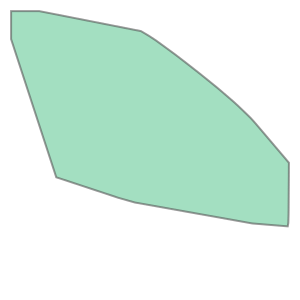

In [117]:
import shapely

points = pathlines[["x", "y"]].to_numpy()
mp = shapely.MultiPoint(points)
hull = shapely.convex_hull(mp)
hull

Compute the total area in square miles.

In [118]:
print(round(hull.area / (5280**2), 2), "sq mi")

1.38 sq mi


We can ask an equivalent question in 3D: how to "shrinkwrap" the entire plume?

In [109]:
import pyvista as pv
from flopy.export.vtk import Vtk

# export to VTK and then to pyvista
vert_exag = 10
vtk = Vtk(
    model=gwf, binary=False, vertical_exageration=vert_exag, smooth=False
)
vtk.add_model(gwf)
vtk.add_pathline_points(pathlines.to_records(index=False))
gwf_mesh, prt_mesh = vtk.to_pyvista()

# reconstruct a surface from the pathline point cloud
filled_mesh = prt_mesh.delaunay_3d()
# filled_mesh = prt_mesh.reconstruct_surface()

# set pyvista options
axes = pv.Axes(show_actor=False, actor_scale=2.0, line_width=5)
pv.set_jupyter_backend("trame")

# set up plot
p = pv.Plotter(
    window_size=[500, 500],
    notebook=True,
)
p.enable_anti_aliasing()
p.add_mesh(gwf_mesh, opacity=0.025, style="wireframe")
p.add_mesh(
    prt_mesh,
    point_size=5,
    line_width=2.5,
    smooth_shading=True,
    color="black",
    opacity=0.2,
)
p.add_mesh(filled_mesh, color="red", opacity=0.2)
p.show()

2024-09-20 16:19:58.343 (1273.138s) [          11F16B]      vtkDelaunay3D.cxx:514   WARN| vtkDelaunay3D (0x2a4ca1920): 45 degenerate triangles encountered, mesh quality suspect


Widget(value='<iframe src="http://localhost:55775/index.html?ui=P_0x2eca3d990_15&reconnect=auto" class="pyvist…

The Delaunay triangulation has the same problem as the `convex_hull` solution in 2D. The reconstruction is terrible, for reasons unknown to me. Can we hack an approximate solution somehow?

Slice the pathline mesh, one slice per timestamp. Note that we are setting time as the active scalar array.

In [110]:
prt_mesh.set_active_scalars("t")
pathline_slices = [
    prt_mesh.extract_values(t, include_cells=False) for t in track_times
]

Stitch a 3D volume together from Delaunay triangulations of each pair of adjacent "frames".

In [111]:
p = pv.Plotter(
    window_size=[500, 500],
    notebook=True,
)
p.enable_anti_aliasing()
p.add_mesh(gwf_mesh, opacity=0.025, style="wireframe")
prev = None
segs = []
for sl in pathline_slices:
    if prev is not None:
        seg = pv.merge([sl, prev]).delaunay_3d()
        segs.append(seg)
    prev = sl
full = pv.merge(segs)
p.add_mesh(full, color="red", opacity=0.2)
p.show()

Widget(value='<iframe src="http://localhost:55775/index.html?ui=P_0x281e96d90_16&reconnect=auto" class="pyvist…

Finally, just for fun, we can create an animation of particle trajectories.

In [112]:
# create the plot
axes = pv.Axes(show_actor=False, actor_scale=2.0, line_width=5)
pv.set_jupyter_backend("trame")
p = pv.Plotter(window_size=[500, 500], notebook=False, off_screen=True)
p.enable_anti_aliasing()
p.add_mesh(gwf_mesh, opacity=0.025, style="wireframe")

p.open_gif("ex3_pathlines.gif")
p.show(auto_close=False)

for i in range(1, len(track_times)):
    p.add_mesh(
        pathline_slices[i], color="red", opacity=0.2, show_scalar_bar=False
    )
    p.write_frame()

p.close()